# Classification Of Pulsar Stars
## Introduction:

Pulsars are rapidly spinning, highly-magnetized neutron stars that send out “pulses” of radiation at regular intervals. Pulsars have a wide range of applications to the scientific research community where they are objects that allows scientists to test general relativity, detect exoplanets, and study the universe. However, pulsar signals can be affected by a range of interference and noise sources, such as radio frequency interference from human-made sources, variations in the Earth's atmosphere, and noise in the instrumentation used to detect the signals. These factors can make it difficult to identify and characterize pulsar signals accurately.

With this project we will try to determine what classifies a pulsar star versus background noise through the training of a knn-model classification model and identify key identifiers to predict whether a given data point is truly a pulsar or not using the HTRU2 dataset found here: https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip. 

The data set is from the UCI machine learning repository. The set contains 1,639 real pulsar star examples, and 16,259 examples of false observations caused by background noise / RFI (radio frequency interference). The HTRU2 dataset contains eight columns, aside from the rightmost column which serves to indicate whether a data point is a pulsar (1) or not (0), each of which provides statistical information about the radio signal emitted by the pulsar candidate. The columns in order from leftmost to rightmost are:
* Mean of the integrated profile: the mean value of the integrated pulse profile, which is a time-series of pulse intensity measurements.
* Standard deviation of the integrated profile: the standard deviation of the integrated pulse profile.
* Excess kurtosis of the integrated profile: a measure of the "peakedness" of the integrated pulse profile compared to a normal distribution.
* Skewness of the integrated profile: a measure of the asymmetry of the integrated pulse profile.
* Mean of the DM-SNR curve: the mean value of the dynamic spectrum (DM-SNR curve), which is a two-dimensional plot of signal power as a function of time and frequency.
* Standard deviation of the DM-SNR curve: the standard deviation of the dynamic spectrum.
* Excess kurtosis of the DM-SNR curve: a measure of the "peakedness" of the dynamic spectrum compared to a normal distribution.
* Skewness of the DM-SNR curve: a measure of the asymmetry of the dynamic spectrum.

In [1]:
# loading libraries into R
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Loading the Data:
The data can be read from it's online source into R

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
temp <- tempfile()
download.file(url, temp)
pulsar <- read_csv(unz(temp, "HTRU_2.csv"), col_names = FALSE)
unlink(temp)
head(pulsar)
tail(pulsar)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
96.0000,44.19311,0.3886740,0.28134362,1.871237,15.83375,9.634927,104.821623,0
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,0
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


> <b> Figure 1 and 2: </b>
    The Pulsar Dataset loaded from the web

## Wrangling & Cleaning the Data:
As we observe our data, we can see there is no column names for all columns. Our first step is to simply use rename() to rename all column names according to attribute information from the data source. Second, we see that our X9, which is the Class column, is using double type for its value. We use mutate() to transfer it to a factor type class, so that we can classify on whether our observation is a pulsar later. 

In [3]:
# renaming the columns in the dataframe
pulsarDataset <- pulsar |>rename( 
                        MeanIP = X1,
                        SD_IP = X2,
                       EK_IP = X3,
                       Skew_IP = X4,
                       Mean_DSNRC = X5,
                       SD_DSNRC = X6,
                       EK_DSNRC = X7,
                       Skew_DSNRC = X8,
                       Class = X9) |>
  mutate(Class = as_factor(Class))
head(pulsarDataset)
tail(pulsarDataset)

MeanIP,SD_IP,EK_IP,Skew_IP,Mean_DSNRC,SD_DSNRC,EK_DSNRC,Skew_DSNRC,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


MeanIP,SD_IP,EK_IP,Skew_IP,Mean_DSNRC,SD_DSNRC,EK_DSNRC,Skew_DSNRC,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
96.0000,44.19311,0.3886740,0.28134362,1.871237,15.83375,9.634927,104.821623,0
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,0
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


> <b> Figure 3 and 4: </b> The Pulsar Dataset with Column names attatched


Now, the data looks tidy and clean. Our next step is to find  means for each variable for pulsars and not-pulsars, as to get a glimpse of how data is different between the two classifications. 

In [4]:
#creating summary table
pulsarDataset_0 <- pulsarDataset |>
    filter(Class == 0)

pulsarDataset_1 <- pulsarDataset |>
    filter(Class == 1)

# summary for class == 0 non-pulsars
pulsarSummary_0 <- tibble(numObs = nrow(pulsarDataset_0),
                        Mean_MeanIP = mean((pulsarDataset_0[,1][[1]])),
                       Mean_SD_IP = mean((pulsarDataset_0[,2][[1]])),
                       Mean_EK_IP = mean((pulsarDataset_0[,3][[1]]),
                       Mean_Skew_IP = mean((pulsarDataset_0[,4][[1]]))),
                       Mean_Mean_DSNRC = mean((pulsarDataset_0[,5][[1]])),
                       Mean_SD_DSNRC = mean((pulsarDataset_0[,6][[1]])),
                       Mean_EK_DSNRC = mean((pulsarDataset_0[,7][[1]])),
                       Mean_Skew_DSNRC = mean((pulsarDataset_0[,8][[1]])),
                       RowsWithMissingData = 0)
## summary for class == 1 pulsars
pulsarSummary_1 <- tibble(numObs = nrow(pulsarDataset_1),
                        Mean_MeanIP = mean((pulsarDataset_1[,1][[1]])),
                       Mean_SD_IP = mean((pulsarDataset_1[,2][[1]])),
                       Mean_EK_IP = mean((pulsarDataset_1[,3][[1]]),
                       Mean_Skew_IP = mean((pulsarDataset_1[,4][[1]]))),
                       Mean_Mean_DSNRC = mean((pulsarDataset_1[,5][[1]])),
                       Mean_SD_DSNRC = mean((pulsarDataset_1[,6][[1]])),
                       Mean_EK_DSNRC = mean((pulsarDataset_1[,7][[1]])),
                       Mean_Skew_DSNRC = mean((pulsarDataset_1[,8][[1]])),
                       RowsWithMissingData = 0)
pulsarSummary_0
pulsarSummary_1

numObs,Mean_MeanIP,Mean_SD_IP,Mean_EK_IP,Mean_Mean_DSNRC,Mean_SD_DSNRC,Mean_EK_DSNRC,Mean_Skew_DSNRC,RowsWithMissingData
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16259,116.5627,47.33974,0.2104401,8.863258,23.28798,8.862674,113.6203,0


numObs,Mean_MeanIP,Mean_SD_IP,Mean_EK_IP,Mean_Mean_DSNRC,Mean_SD_DSNRC,Mean_EK_DSNRC,Mean_Skew_DSNRC,RowsWithMissingData
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1639,56.69061,38.7106,3.130655,49.826,56.46896,2.757069,17.93173,0


> <b> Figure 5 and 6: </b> The mean of each varriable of non-pulsar observations, and pulsar observations respectively


We can observe that each characteristic above can likely indicate whether the star is a pulsar or not, given that there are large differences observed in the mean of each characteristic between pulsar and non-pulsar observations. This means we can likely use every variable in our dataset as a predictor variable in our model, but we will confirm this intution with a further test.

## Exploratory Analysis:

In order to use a knn-classification model to classify pulsar-candidates as pulsars or not pulsars, we must first determine which variables can be used as predictor variables. To confirm our earlier claim that all variables in our dataset can be used as predictory variables, we compared the density distributions of each characteristic for pulsars and not-pulsars. This lets us see which variables have different distribution for pulsars and not-pulsars. 

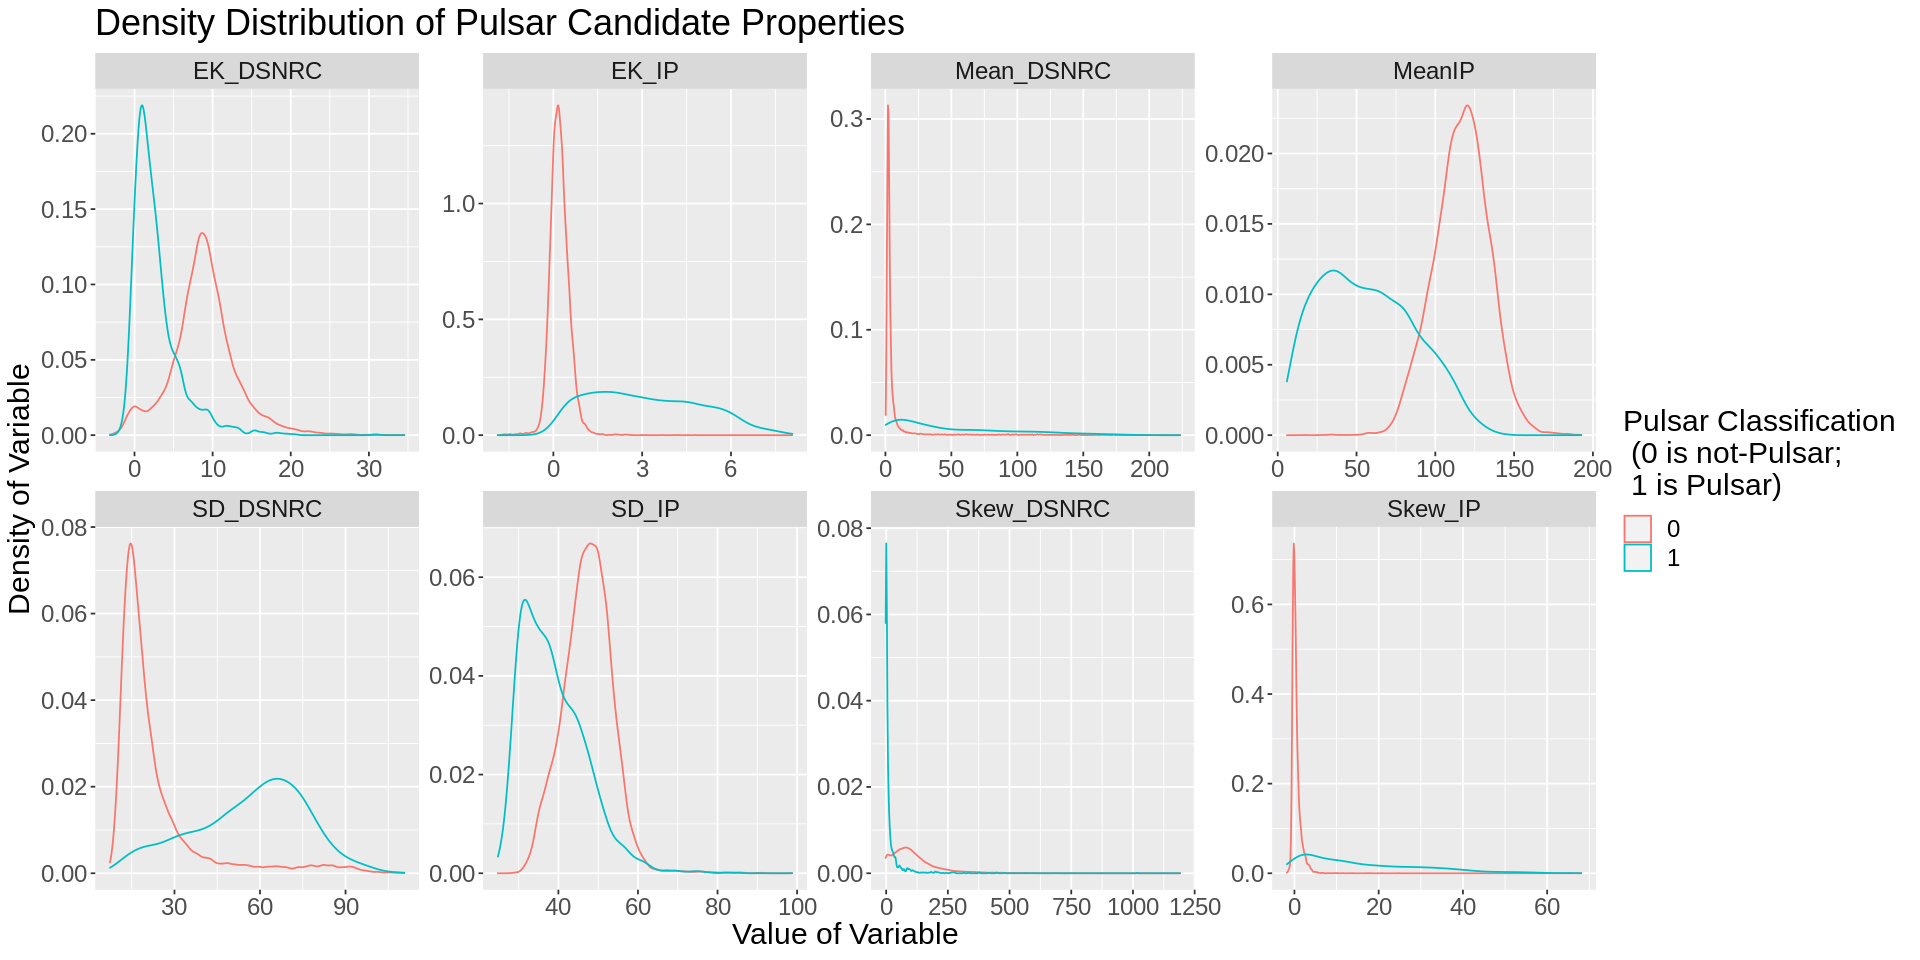

In [5]:
options(repr.plot.width = 16, repr.plot.height =8)

#creating distribution plot
pulsar_plot <- pulsarDataset |>
    pivot_longer(1:8) |>
    ggplot(aes(x = value)) +
    geom_density(aes(color = Class)) +
    facet_wrap(~name, ncol = 4, scales="free") + 
    labs(x= "Value of Variable",  y = "Density of Variable", color = "Pulsar Classification \n (0 is not-Pulsar; \n 1 is Pulsar)") + 
    ggtitle("Density Distribution of Pulsar Candidate Properties") + 
    theme(text = element_text(size = 18))


pulsar_plot

> <b> Figure 7: </b> Density distributions across each of the predictor varriables for pulsars (blue) and non-pulsars (red)

As we can see from the above plots (figure 7), all 8 variables have different distributions whether the data point is a pulsar or not, so we confirm that all 8 variables can be used as predictor variables. 

## Data Analysis:
First we need to split our data into both a training and testing data set. For the purposes of our analysis we used a 75-25 split, to allow for sufficient data to both train and test our model. Before splitting our data, it is important to balance the dataset so as not to skew our accuracy in any way. We do this by taking a random sample of our class 0 (not pulsar) observations of equal size to our class 1 (pulsar) observations

In [6]:
#set seed
set.seed(1234)
# balancing dataset to have equal class 1 and class 0 rows
pulsar_dataset_balanced <- bind_rows(
    filter(pulsarDataset, Class == 1),
    filter(pulsarDataset, Class == 0) |> sample_n(1639))

#splitting data into training and testing sets
pulsar_split = initial_split(pulsar_dataset_balanced, prop = 0.75, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

The first step towards creating our model is figuring out what value of k we should use. The value of k determines the number of neighbours that are factored into the classification of a predicted point. First, we can create a recipie involving all of our prediction varriables we established above.

In [7]:
set.seed(1234)
#creating a recipe
pulsar_recipe <- recipe(Class ~ MeanIP +  SD_IP +  EK_IP +  Skew_IP +  Mean_DSNRC +  SD_DSNRC +  EK_DSNRC +  Skew_DSNRC,   data = pulsar_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

After creating our recipie and scaling our data, we can create a model that will use 5 fold cross-validation and try 30 different k values, which we can then sort by accuracy. Using the "tune()" function allows us to better tune our model in training, and we can create a workflow to combine our steps to try all 30 k values more efficiently

In [8]:
set.seed(1234)
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = Class)

# creating a model which can be tuned
pulsar_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

## try k values 1 through 30
k_value <- tibble(neighbors = seq(from = 1, to =30, by =1))

# workflow to combine analysis steps
pulsar_results <- workflow() |>
      add_recipe(pulsar_recipe) |>
      add_model(pulsar_tune) |>
      tune_grid(resamples = pulsar_vfold, grid = k_value) |>
      collect_metrics()

# dataframe of accuracy results
accuracies <- pulsar_results |>
      filter(.metric == "accuracy")

Then we can graph the data to make it more clear to us which k value we should choose

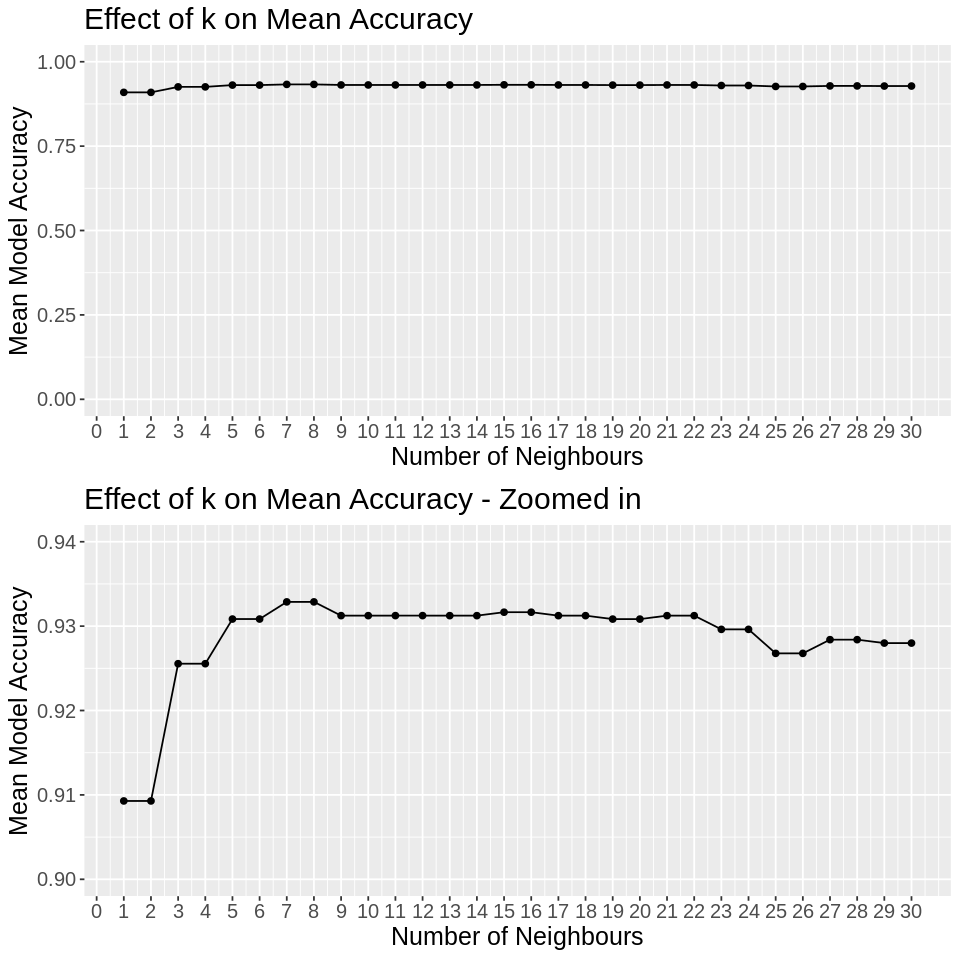

In [9]:
set.seed(1234)
# graph of accuracy
options(repr.plot.width = 8, repr.plot.height =8)
cross_validation_results_plot <- ggplot(accuracies, aes(x= neighbors, y = mean)) +
        geom_point() + 
        geom_line() + 
        ggtitle("Effect of k on Mean Accuracy") +
        labs(x="Number of Neighbours", y="Mean Model Accuracy") + 
        ylim(c(0.0,1)) + 
        scale_x_continuous(breaks = seq(0, 30, by = 1)) + 
        theme(text = element_text(size = 15))

# zoomed in graph of accuracy to improve visibility
cross_validation_results_plot_2 <- ggplot(accuracies, aes(x= neighbors, y = mean)) +
        geom_point() + 
        geom_line() + 
        ggtitle("Effect of k on Mean Accuracy - Zoomed in") +
        labs(x="Number of Neighbours", y="Mean Model Accuracy") + 
        ylim(c(0.90,0.94)) +
        scale_x_continuous(breaks = seq(0, 30, by = 1)) + 
        theme(text = element_text(size = 15))

plot_grid(cross_validation_results_plot, cross_validation_results_plot_2, ncol = 1)

> <b> Figure 8 and 9: </b> The mean model accuracy of each possible k value

From the graph (figure 8 and 9), we can see that while there is not a significant change in accuracy as we change the number of neighbours, we see the highest accuracy at k = 8. We can now re-create the prediction model using k = 8. This time, instead of using the tune() function, we can set the number of neighbours to 8 directly. We can then use a workflow to combine our recipe and model, and fit the training dataset.

In [10]:
#set seed
set.seed(1234)

#recreate model with best k value

pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
       set_engine("kknn") |>
       set_mode("classification")

pulsar_fit <- workflow() |>
       add_recipe(pulsar_recipe) |>
       add_model(pulsar_spec) |>
       fit(data = pulsar_train)

We can then compare how our predictions fared against the actual findings of our testing dataset. We can combine the tables of true values we gathered from the original dataset, and our predicted values using our model, then we can compare to find how well we did.

In [11]:
# fit the predictions to the actual values
pulsar_predictions <- predict(pulsar_fit , pulsar_test) |>
      bind_cols(pulsar_test)

# table of accuracies
pulsar_metrics <- pulsar_predictions |>
       metrics(truth = Class, estimate = .pred_class)

# confusion matrix of predicitons and truths
pulsar_conf_mat <- pulsar_predictions |>
       conf_mat(truth = Class, estimate = .pred_class)

pulsar_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9158537
kap,binary,0.8317073


> <b> Figure 10: </b> The observed model accuracy of using k = 8 to classify an unknown point

In [12]:
pulsar_conf_mat

          Truth
Prediction   0   1
         0 392  51
         1  18 359



> <b> Figure 11: </b> The predicted values and actual values for all data in test set

We can see that we had an overal accuracy of over 91%. However, our model performed significantly better at predicting the truth of non-pulsar observations (interfearence) than it did actual pulsar observations, which it did with an accuracy of around 86%

## Discussion

The main focus of the project was to analyze which columns in the HTRU2 data set provided meaningful figures that can be used to distinguish between pulsar stars and background radio frequencies and to train a knn classification model to do so.

Through the <u>Exploratory Analysis</u> section we first analyzed the distribution curves of each variable in the given data set to determine whether a given variable was a good indicator or not, finding that all eight columns provided meaningful statistical data which served in training the classification model in the following <u>Data Analysis</u> sections where the data set was rebalanced to account for the lack of positive pulsar data points and cross-validation was used to determine the best k-value to use. Following this, the found best k-value (k = 8), was then used to train a model and its accuracy was evaluated on the testing data set.

Upon evaluating the accuracy of our model on the testing set it was found our model had an accuracy of 87.6% when classifying pulsars and an accuracy of 95.6% when classifying background frequencies (refer to <i>Figure 11</i> for the confusion matrix). This level of accuracy is reasonably high and exceeds the expectations as set out by the group and holds a comparable, albeit lower, degree of accuracy to 2018 study <i>Pulsar candidate recognition with deep learning</i> (Zhang, et al.). Given the nature of the problem at hand it is still be worthwhile to seek a more accurate option. With the miscalculation costs of misidentifying a pulsar as background noise, or vice versa, the scientific community loses a potential object of study or gains a false lead which could affect future scientific findings and their accuracy. Not to mention the costs associated with operating the precise scientific instruments needed to detect, measure, and quantify the received signals.

However, in the case that an appropriately accurate pulsar classification training model was developed, the effect it could have on future astrophysical studies would be massive. By providing scientists with additional objects of research and interest the accurate model could enable the discovery of new pulsars that were previously undetected or misclassified. This could lead to a better understanding of the population of pulsars and their properties, as well as the underlying physical mechanisms that produce pulsar emission. Further pulsar research enabled by an accurate model also could lead to technological advancements in the techniques and tools used for radio astronomy and signal processing. This could lead to better telescope designs, data analysis methods, and instrument calibration techniques, benefiting the scientific community as a whole.

Moving forward, it may be worthwhile to further expand on the processes discussed above to additional concepts. One such being the further improvement of the accuracy of the model, there may be potential identifiers that remain undiscovered or classification models and strategies that result in more consistent prediction. Diverging from pulsar classification, it may also prove worthwhile to apply the classification methods to additional astronomical phenomena, are there identifiers which they share? What separates different types of phenomena more distinctly? Are there additional variations of pulsars not yet classified?

## References

UCI Machine Learning Repository: HTRU2 Data Set. (n.d.). Archive.ics.uci.edu. Retrieved April 11, 2023, from https://archive.ics.uci.edu/ml/datasets/HTRU2#

Lee, K. J., Guillemot, L., Yue, Y. L., Kramer, M., & Champion, D. J. (2012). Application of the Gaussian mixture model in pulsar astronomy 
pulsar classification and candidates ranking for the Fermi 2FGL catalogue. Monthly Notices of the Royal Astronomical Society, 424(4), 2832–2840. 
https://doi.org/10.1111/j.1365-2966.2012.21413.x

Haoyuan Zhang, Zhen Zhao, Tao An, Baoqiang Lao, Xiao Chen, (2019). Pulsar candidate recognition with deep learning,
Computers & Electrical Engineering, Volume 73, Pages 1-8,
ISSN 0045-7906,
https://doi.org/10.1016/j.compeleceng.2018.10.016.